# mount drive

In [1]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [2]:
# import packages
import datetime
import holidays
import itertools
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

### 015-1
014-3 (学習データ全体の中央値を特徴量に追加)に1日前，1週間前のシフト特徴量を追加  
特徴量からorgフラグ消し忘れ

In [109]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [110]:
# trainとtestをまとめる
data = pd.concat([train, test])
print(len(data))

851175


In [111]:
# 元データであるかどうかのフラグ
data["org"] = True

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [112]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isSat"] = (data.weekday == 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [113]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標と方角をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction"])

# 元データのみ取り出す
data = data[data.org]

In [114]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "shift_feature"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "shift_feature"], axis=1)

In [115]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.80888	valid_1's l1: 9.78498
[20]	training's l1: 7.68933	valid_1's l1: 7.69823
[30]	training's l1: 6.64616	valid_1's l1: 6.70161
[40]	training's l1: 6.14858	valid_1's l1: 6.24584
[50]	training's l1: 5.90675	valid_1's l1: 6.04745
[60]	training's l1: 5.78274	valid_1's l1: 5.96005
[70]	training's l1: 5.71929	valid_1's l1: 5.9224
[80]	training's l1: 5.68305	valid_1's l1: 5.91345
[90]	training's l1: 5.65958	valid_1's l1: 5.91957
Early stopping, best iteration is:
[80]	training's l1: 5.68305	valid_1's l1: 5.91345
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.81269	valid_1's l1: 9.98263
[20]	training's l1: 7.71446	valid_1's l1: 7.90692
[30]	training's l1: 6.68175	valid_1's l1: 6.88672
[40]	training's l1: 6.19295	valid_1's l1: 6.40482
[50]	training's l1: 5.96154	valid_1's l1: 6.18252
[60]	training's l1: 5.84983	valid_1's l1

In [116]:
with open("../output/y_preds_015-1.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_015-1.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_015-1.pkl", "wb") as f:
    pickle.dump(oof_train, f)

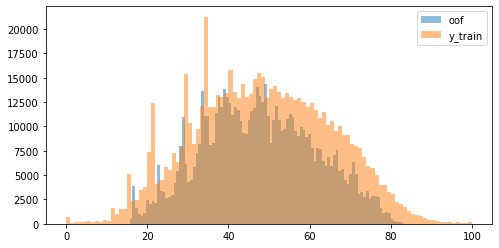

In [117]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [118]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.913451355950182, 6.026172918196433, 6.347203151923371, 5.947948380667242, 6.317836308948511]
6.110522423137148


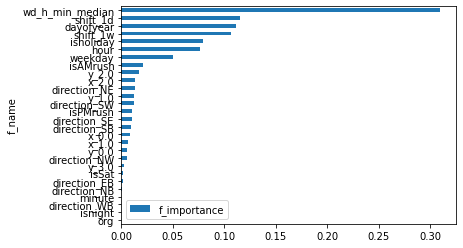

In [119]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### submit

In [120]:
with open("../output/y_preds_015-1.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_015-1.csv", index=False)

In [121]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [122]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_015-1.csv -m "015-1"

100% 57.6k/57.6k [00:02<00:00, 21.1kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022